In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix

import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

from catboost import CatBoostRegressor

In [77]:
def timestamp_data_treatment(dataset, category='1ofN'):
    if category == 'binary':
        for column in ['Dia', 'Mes', 'Hora Medicao']:
            date = dataset[column]
            _max = date.max()
            i = 0
            while 2**i < _max:
                i += 1
            binary_rep = [np.binary_repr(z,width=i) for z in date.astype('int')]
            d = []
            for k in range(i):
                d.append(np.array([int(v) for s in binary_rep for v in s[k]]))
            t = np.vstack((d)).T
            if column == 'Mes':
                df_mes = pd.DataFrame(t, columns= [f'Bit_Mes_{ind}' for ind in range(i)])
            else:
                df_hora = pd.DataFrame(t, columns= [f'Bit_Hora_{ind}' for ind in range(i)])

    elif category == '1ofN':
        for column in ['Dia','Mes','Hora Medicao']:
            one_hot = pd.get_dummies(dataset[column])
            listoflists = one_hot.values.tolist()
            new_list = []
            for lists in listoflists:
                new_list.append(''.join(map(str, lists)))
            d = []
            if column == 'Mes':
                for k in range(12):
                        d.append(np.array([int(v) for s in new_list for v in s[k]]))
                t = np.vstack((d)).T
                df_mes = pd.DataFrame(t, columns= ['Jan', 'Fev', 'Mar','Abr','Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
            if column == 'Hora Medicao':
                for k in range(24):
                        d.append(np.array([int(v) for s in new_list for v in s[k]]))
                t = np.vstack((d)).T
                df_hora = pd.DataFrame(t, columns= [f'{ind} h' for ind in range(24)])
            if column == 'Dia':
                for k in range(24):
                        d.append(np.array([int(v) for s in new_list for v in s[k]]))
                t = np.vstack((d)).T
                df_hora = pd.DataFrame(t, columns= [f'{ind} h' for ind in range(24)])
    
    else:
        for column in ['Dia', 'Mes','Hora Medicao']:
            _values = dataset[column].values
            _max = dataset[column].max()
            
            _array = np.array([float(i/_max) for i in _values])
            if column == 'Mes':
                df_mes = pd.DataFrame(_array, columns= ['Mes'])
            else:
                df_hora = pd.DataFrame(_array, columns= ['Horas'])


    return df_mes, df_hora    


def preparing_data(dataset, features = [], lag = 24, normalize = 'minmax', category = 'binary', onlyHour = False, onlyMonth = False):
    _max = dataset.iloc[:,-1:].max().values
    _min = dataset.iloc[:,-1:].min().values
    _med = dataset.iloc[:,-1:].mean().values
    _std = dataset.iloc[:,-1:].std().values
    if normalize == 'standard':
        scaler = StandardScaler()
        dataset_norm = scaler.fit_transform(dataset.drop([i for i in dataset.columns if i in ['Dia', 'Mes', 'Ano', 'Hora Medicao']],axis=1))
        dataset_norm = pd.DataFrame(dataset_norm, 
                                    columns = dataset.drop([i for i in dataset.columns if i in ['Dia', 'Mes', 'Ano', 'Hora Medicao']],axis=1).columns)
    else:
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset_norm = scaler.fit_transform(dataset.drop([i for i in dataset.columns if i in ['Dia', 'Mes', 'Ano', 'Hora Medicao']],axis=1))
        dataset_norm = pd.DataFrame(dataset_norm, 
                                   columns = dataset.drop([i for i in dataset.columns if i in ['Dia', 'Mes', 'Ano', 'Hora Medicao']],axis=1).columns)
        
    X, Y = look_back_function(dataset_norm['VENTO, VELOCIDADE HORARIA(m/s)'],lag)
#     trend = pd.DataFrame(X.iloc[:, -1] - X.iloc[:, -2], columns = ['Trend'])
#     X = pd.concat([trend, X], axis = 1)
    mes, hora = timestamp_data_treatment(dataset, category)
    
    if len(features):
        for feature in features:
            if feature in dataset_norm.drop([i for i in dataset_norm.columns if i in ['Dia', 'Mes', 'Ano', 'Hora Medicao']], axis=1).columns:
                X = pd.concat([dataset_norm[feature][lag:-1].reset_index(drop=True), X], axis=1)
        
    if onlyMonth:
        _input = pd.concat([mes[lag:-1].reset_index(drop=True), X], axis=1)
        
    elif onlyHour:
        _input = pd.concat([hora[lag:-1].reset_index(drop=True), X], axis=1)
        
    else:
        _input = pd.concat([mes[lag:-1].reset_index(drop=True), hora[lag:-1].reset_index(drop=True), X], axis=1)
    
    return _input, Y,_max, _min, _med, _std
        

def look_back_function (dataset, look_back=24):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    X = pd.DataFrame(np.array(dataX), columns = [f'X(t-{ind})' for ind in reversed(range(look_back))])
    Y = pd.DataFrame(np.array(dataY), columns=['Output'])
    return X, Y

def multistep_prediction(model, Input, lag):
    other_features = Input.iloc[:, :(Input.shape[1]-lag)]
    other_features_array = other_features.values

    wind_feature = Input.iloc[:,-lag:]
    wind_feature_array = wind_feature.values

    for i in range(len(wind_feature_array)):
        if i==0:
            x_multistep = np.concatenate((other_features_array[i],wind_feature_array[i]))
            _y_hat = model.predict(x_multistep.reshape(1,-1))
            predict_array = np.array(_y_hat)
        else:
            if i < lag:
                wind_array_copy =  wind_feature_array[i, :]
                wind_array_copy = wind_array_copy[:-predict_array.shape[0]]
                data_array_with_prediction = np.insert(wind_array_copy,wind_array_copy.size,predict_array)
            else:
                data_array_with_prediction = predict_array[-lag:]
            x_multistep = np.concatenate((other_features_array[i],data_array_with_prediction))
            _y_hat = model.predict(x_multistep.reshape(1,-1))
            predict_array = np.append(predict_array, _y_hat)
    predict_data = pd.DataFrame(predict_array, columns=['Predictions'])
    return predict_data

def mask_classification(raw_data):
    classification_list = np.array([])
    for idx, x in raw_data.iterrows():
        if 0 <= x.values <= 4:
            classification_list = np.append(classification_list, 1)
        elif 4 < x.values <= 10:
            classification_list = np.append(classification_list, 2)
        elif 10 < x.values <= 15:
            classification_list = np.append(classification_list, 3)
        elif 15 < x.values <= 25:
            classification_list = np.append(classification_list, 4)
        else:
            classification_list = np.append(classification_list, 5)
    return classification_list

def MAPE(testY, testPredict):
    soma, cont = 0, 0
    for idx, value in testY.iterrows():
        if abs(value.values) >= 0.01:
            erro = abs((value - testPredict.values[idx])/value)
            soma += erro
            cont += 1
    mape = (soma/cont)*100
    return mape

In [3]:
df_train_micetreated = pd.read_csv('Treino_Arraial_do_Cabo_MICE.csv', sep = ';')
df_test_micetreated = pd.read_csv('Teste_Arraial_do_Cabo_MICE.csv', sep = ';')

In [4]:
df = pd.concat([df_train_micetreated, df_test_micetreated])
df = df.drop([i for i in df.columns if i in 
              ['Dia', 'Mes', 'Ano', 'Hora Medicao', 'TEMPERATURA DA CPU DA ESTACAO(°C)', 'TENSAO DA BATERIA DA ESTACAO(V)']],axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
df_norm = scaler.fit_transform(df)
df_norm = pd.DataFrame(df_norm, columns = df.columns)

**Seleção de Features**

In [5]:
#Backward Elimination
_x = df_norm.drop([i for i in df_norm.columns if i in ['VENTO, VELOCIDADE HORARIA(m/s)']],axis=1)
_y = df_norm["VENTO, VELOCIDADE HORARIA(m/s)"]
cols = list(_x.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = _x[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(_y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['PRECIPITACAO TOTAL, HORARIO(mm)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'PRESSAO ATMOSFERICA REDUZIDA NIVEL DO MAR, AUT(mB)', 'PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT)(mB)', 'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT)(mB)', 'RADIACAO GLOBAL(Kj/m�)', 'TEMPERATURA DA CPU DA ESTACAO(�C)', 'TEMPERATURA DO AR - BULBO SECO, HORARIA(�C)', 'TEMPERATURA DO PONTO DE ORVALHO(�C)', 'TEMPERATURA MAXIMA NA HORA ANT. (AUT)(�C)', 'TEMPERATURA MINIMA NA HORA ANT. (AUT)(�C)', 'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)(�C)', 'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)(�C)', 'UMIDADE RELATIVA DO AR, HORARIA(%)', 'VENTO, DIRECAO HORARIA (gr)(� (gr))', 'VENTO, RAJADA MAXIMA(m/s)']


In [6]:
#RFE
nof_list=np.arange(1,df_norm.shape[1])            
high_score=0

nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(_x,_y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
cols = list(_x.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, nof)

#Transforming data using RFE
X_rfe = rfe.fit_transform(_x,_y)

#Fitting the data to model
model.fit(X_rfe,_y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

c:\users\diego\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
c:\users\diego\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
c:\users\diego\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
c:\users\diego\a

Optimum number of features: 16
Score with 16 features: 0.853087
Index(['PRECIPITACAO TOTAL, HORARIO(mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)',
       'PRESSAO ATMOSFERICA REDUZIDA NIVEL DO MAR, AUT(mB)',
       'PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT)(mB)',
       'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT)(mB)',
       'RADIACAO GLOBAL(Kj/m�)', 'TEMPERATURA DA CPU DA ESTACAO(�C)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA(�C)',
       'TEMPERATURA DO PONTO DE ORVALHO(�C)',
       'TEMPERATURA MAXIMA NA HORA ANT. (AUT)(�C)',
       'TEMPERATURA MINIMA NA HORA ANT. (AUT)(�C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)(�C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)(�C)',
       'UMIDADE RELATIVA DO AR, HORARIA(%)',
       'VENTO, DIRECAO HORARIA (gr)(� (gr))', 'VENTO, RAJADA MAXIMA(m/s)'],
      dtype='object')


Best alpha using built-in LassoCV: 0.000016
Best score using built-in LassoCV: 0.852889
['PRECIPITACAO TOTAL, HORARIO(mm)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT)(mB)', 'RADIACAO GLOBAL(Kj/m�)', 'TEMPERATURA DA CPU DA ESTACAO(�C)', 'TEMPERATURA MAXIMA NA HORA ANT. (AUT)(�C)', 'TEMPERATURA MINIMA NA HORA ANT. (AUT)(�C)', 'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)(�C)', 'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)(�C)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'UMIDADE RELATIVA DO AR, HORARIA(%)', 'VENTO, DIRECAO HORARIA (gr)(� (gr))', 'VENTO, RAJADA MAXIMA(m/s)']
Lasso picked 13 variables and eliminated the other 5 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

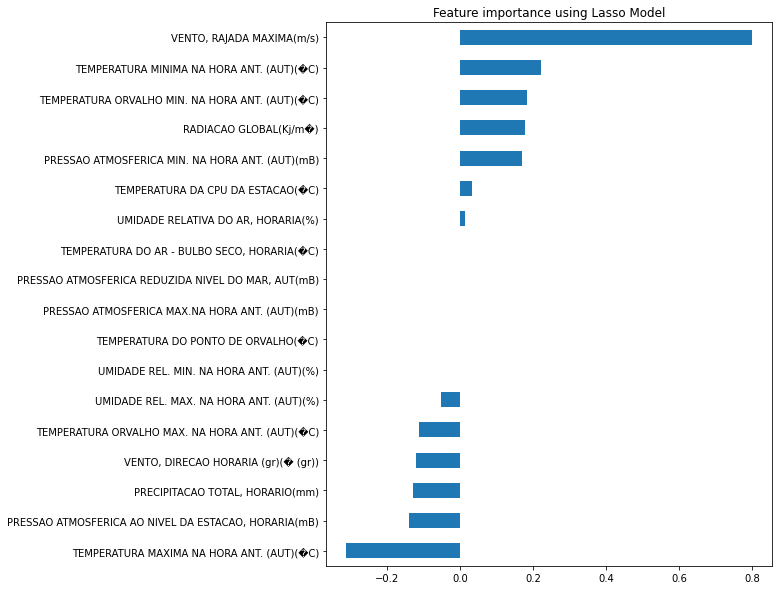

In [7]:
#EMbedded Method
reg = LassoCV()
reg.fit(_x, _y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(_x, _y))
coef = pd.Series(reg.coef_, index = _x.columns)

list_embedded = []
for ind, value in coef.iteritems():
    if value != 0:
        list_embedded.append(ind)
print(list_embedded)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()

mpl.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [ ]:
forest = RandomForestRegressor(max_depth = 5, random_state = 42)

boruta_feature_selector = BorutaPy(forest, n_estimators='auto', verbose=0, random_state=4242, max_iter = 100, perc = 75)
boruta_feature_selector.fit(np.array(_x), np.array(_y))

final_features = list()
indexes = np.where(boruta_feature_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(df.columns[x])
print(final_features)

In [8]:
final_features = ['PRECIPITACAO TOTAL, HORARIO(mm)', 'RADIACAO GLOBAL(Kj/m�)', 'VENTO, DIRECAO HORARIA (gr)(� (gr))', 'VENTO, RAJADA MAXIMA(m/s)']

**Interseção de Features**

In [9]:
backward_elimination_list = set(selected_features_BE)
RFE_list = set(selected_features_rfe)
embedded_method_list = set(list_embedded)
boruta_method_list = set(final_features)

BE_RFE_List = backward_elimination_list.intersection(RFE_list)
EM_BE_RFE_List = BE_RFE_List.intersection(embedded_method_list)
final_feature_list = list(EM_BE_RFE_List.intersection(boruta_method_list))

print(final_feature_list)

['VENTO, DIRECAO HORARIA (gr)(� (gr))', 'VENTO, RAJADA MAXIMA(m/s)', 'PRECIPITACAO TOTAL, HORARIO(mm)', 'RADIACAO GLOBAL(Kj/m�)']


**Previsão Horizonte 1 dia**

**Seleção de hiper-parâmetros utilizando algoritmos genéticos**

In [78]:
from xgboost import XGBRegressor
from deap import base, creator, tools, algorithms
import random

def mutate(individual):
    
    gene = random.randint(0,10) #select which parameter to mutate
    if gene == 0:
        if individual[0] == 3:
            individual[0] = random.choice([6, 12, 24])
        elif individual[0] == 6:
            individual[0] = random.choice([3, 12, 24])
        elif individual[0] == 12:
            individual[0] = random.choice([3, 6, 24])
        else:
            individual[0] = random.choice([3, 6, 12])
    elif gene == 1:
        if individual[1] == 'minmax':
            individual[1] = 'standard'
        else:
            individual[1] = 'minmax'
    elif gene == 2:
        if individual[2] == 'numeric':
            individual[2] = random.choice(['1ofN', 'binary'])
        elif individual[2] == '1ofN':
            individual[2] = random.choice(['numeric', 'binary'])
        else:
            individual[2] = random.choice(['numeric', '1ofN'])
        
    elif gene == 3:
        if individual[3] == True:
            individual[3] = False
        else:
            individual[3] = True

    elif gene == 4:
        if individual[4] == True:
            individual[4] = False
        else:
            individual[4] = True
    elif gene == 5:
        individual[5] = random.randint(lower_n_stimators, upper_n_stimators)
    
    elif gene == 6:
        individual[6] = random.randint(lower_max_depth, upper_max_depth)
        
    elif gene == 7:
        individual[7] = random.uniform(lower_eta, upper_eta) 
        
    elif gene == 8:
        individual[8] = random.uniform(lower_subsample, upper_subsample) 
    
    elif gene == 9:
        individual[9] = random.uniform(lower_subsample, upper_subsample)
    
    elif gene == 10:
        individual[10] = random.uniform(lower_lr, upper_lr)
        
    return individual,


def evaluate(individual):
    '''
    build and test a model based on the parameters in an individual and return
    the AUROC value
    '''
    # extract the values of the parameters from the individual chromosome
    
    _lag = individual[0]
    _normalize = individual[1]
    _category = individual[2]
    _month = individual[3]
    _hour = individual[4]
    _n_stimators = individual[5]
    _max_depth = individual[6]
    _eta = individual[7]
    _subsample = individual[8]
    _colsample_bytree = individual[9]
    _lr = individual[10]
    
    print(f'Train_Lag: {_lag}')
    print(f'Train_Norm: {_normalize}')
    print(f'Train_Category: {_category}')
    print(f'Train_Hour: {_hour}')
    print(f'Train_Month: {_month}')
    X_train, Y_train,_maxtrain, _mintrain, _meantrain, _stdtrain = preparing_data(df_train_micetreated, lag = _lag, normalize = _normalize, category = _category, onlyHour = _hour, onlyMonth = _month)
    X_test, Y_test,_maxtest, _mintest, _meantest, _stdtest = preparing_data(df_test_micetreated,lag = _lag, normalize = _normalize, category = _category, onlyHour = _hour, onlyMonth = _month)    
    X_test_day = X_test[-24:].reset_index(drop=True)
    Y_test_day = Y_test[-24:].reset_index(drop=True)
    # build the model
    print(f'n_stimators: {_n_stimators}')
    print(f'max_depth: {_max_depth}')
    print(f'eta: {_eta}')
    print(f'subsample: {_subsample}')
    print(f'colsample_bytree: {_colsample_bytree}')
    print(f'learning_rate: {_lr}')
    xgbmodel = XGBRegressor(n_estimators=_n_stimators, 
                         max_depth=_max_depth,
                         eta=_eta, subsample=_subsample,
                         colsample_bytree=_colsample_bytree,
                         learning_rate = _lr)
    
    xgbmodel.fit(X_train,Y_train)

    testpredictXGB = multistep_prediction(xgbmodel, X_test_day, _lag)

    if _normalize == 'standard':
        orig_y_eval_test = Y_test_day*(_stdtest) + _meantest
        orig_y_hat_test = testpredictXGB*(_stdtest) + _meantest
    else:
        orig_y_eval_test = Y_test_day*(_maxtest - _mintest) + _mintest
        orig_y_hat_test = testpredictXGB*(_maxtest - _mintest) + _mintest
        
    mape = MAPE(orig_y_eval_test, orig_y_hat_test)
    RMSE_test = (mean_squared_error(orig_y_eval_test, orig_y_hat_test))**0.5
    print(f'RMSE: {RMSE_test}')
    print(f'MAPE: {mape}')
    print('----'*20)
    return RMSE_test,


creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Maximise the fitness function value
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Possible parameter values
lag_option = [3, 6, 12, 24]
norm = ['minmax', 'standard']
cat = ['numeric', '1ofN', 'binary']
hour = [True, False]
month = [True, False]
lower_n_stimators, upper_n_stimators = 50,500 
lower_max_depth, upper_max_depth = 1,15
lower_eta, upper_eta = 0.01,0.2
lower_subsample, upper_subsample = 0.5,1
lower_colsample_bytree, upper_colsample_bytree = 0.5,1
lower_lr, upper_lr = 0.05,0.5

N_CYCLES = 1
toolbox.register("attr_lag", random.choice, lag_option)
toolbox.register("attr_normalization", random.choice, norm)
toolbox.register("attr_category", random.choice, cat)
toolbox.register("attr_hour", random.choice, hour)
toolbox.register("attr_month", random.choice, month)
toolbox.register("attr_n_stimators", random.randint, lower_n_stimators, upper_n_stimators)
toolbox.register("attr_max_depth", random.randint, lower_max_depth, upper_max_depth)
toolbox.register("attr_eta", random.uniform, lower_eta, upper_eta)
toolbox.register("attr_subsample", random.uniform, lower_subsample, upper_subsample)
toolbox.register("attr_colsample_bytree", random.uniform, lower_colsample_bytree, upper_colsample_bytree)
toolbox.register("attr_lr", random.uniform, lower_lr, upper_lr)

toolbox.register("individual", tools.initCycle, creator.Individual,(toolbox.attr_lag,
                                                                    toolbox.attr_normalization, toolbox.attr_category,
                                                                    toolbox.attr_hour,toolbox.attr_month,
                                                                    toolbox.attr_n_stimators,toolbox.attr_max_depth,
                                                                    toolbox.attr_eta,toolbox.attr_subsample,
                                                                    toolbox.attr_colsample_bytree,toolbox.attr_lr), n=N_CYCLES)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)


toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate",mutate)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("evaluate", evaluate)

population_size = 10
crossover_probability = 0.75
mutation_probability = 0.05
number_of_generations = 20

pop = toolbox.population(n=population_size)
hof_day = tools.HallOfFame(3)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=crossover_probability, stats = stats, mutpb = mutation_probability, ngen=number_of_generations, halloffame=hof_day, verbose=True) 

day_best_parameters_1 = hof_day[0] # save the optimal set of parameters
day_best_parameters_2 = hof_day[1]
day_best_parameters_3 = hof_day[2]
print(day_best_parameters_1)
print(day_best_parameters_2)
print(day_best_parameters_3)

gen_day = log.select("gen")
max_day = log.select("max")
avg_day = log.select("avg")
min_day = log.select("min")

c:\users\diego\appdata\local\programs\python\python39\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\users\diego\appdata\local\programs\python\python39\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Train_Lag: 12
Train_Norm: standard
Train_Category: numeric
Train_Hour: True
Train_Month: True
n_stimators: 128
max_depth: 4
eta: 0.11831854434262122
subsample: 0.9357927055930764
colsample_bytree: 0.794498617874204
learning_rate: 0.2704953648876437
RMSE: 3.036331123942531
MAPE: Output    44.364336
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 6
Train_Norm: minmax
Train_Category: numeric
Train_Hour: False
Train_Month: True
n_stimators: 238
max_depth: 2
eta: 0.014254981783547947
subsample: 0.861754366882579
colsample_bytree: 0.9883798052282162
learning_rate: 0.434604175338276
RMSE: 2.8816995559437095
MAPE: Output    42.416229
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 24
Train_Norm: standard
Train_Category: numeric
Train_Hour: False
Train_Month: True
n_stimators: 352
max_depth: 10
eta: 0.09377098905207003
subsample: 0.6307579792125733
colsample_by

n_stimators: 151
max_depth: 13
eta: 0.09293594959034812
subsample: 0.5793263437452483
colsample_bytree: 0.9379793482309853
learning_rate: 0.43166996424389764
RMSE: 2.5395272844558714
MAPE: Output    33.892957
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 12
Train_Norm: standard
Train_Category: numeric
Train_Hour: True
Train_Month: False
n_stimators: 151
max_depth: 10
eta: 0.09377098905207003
subsample: 0.6307579792125733
colsample_bytree: 0.711180875487585
learning_rate: 0.33189521431205915
RMSE: 2.1370693334869504
MAPE: Output    33.848955
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 12
Train_Norm: standard
Train_Category: numeric
Train_Hour: False
Train_Month: False
n_stimators: 52
max_depth: 10
eta: 0.04087909398144296
subsample: 0.8876237091384696
colsample_bytree: 0.6550941444578477
learning_rate: 0.17765798074821015
RMSE: 2.337747038694872
M

n_stimators: 151
max_depth: 10
eta: 0.09377098905207003
subsample: 0.6307579792125733
colsample_bytree: 0.711180875487585
learning_rate: 0.33189521431205915
RMSE: 2.1370693334869504
MAPE: Output    33.848955
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 12
Train_Norm: standard
Train_Category: numeric
Train_Hour: True
Train_Month: False
n_stimators: 151
max_depth: 10
eta: 0.09377098905207003
subsample: 0.6307579792125733
colsample_bytree: 0.711180875487585
learning_rate: 0.33189521431205915
RMSE: 2.1370693334869504
MAPE: Output    33.848955
Name: 0, dtype: float64
--------------------------------------------------------------------------------
4  	10    	2.35648	0.339249	1.9772 	2.94386
Train_Lag: 12
Train_Norm: standard
Train_Category: numeric
Train_Hour: True
Train_Month: False
n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.9884286697278168
colsample_bytree: 0.590675560632129
learning_rate: 0.17

n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.9884286697278168
colsample_bytree: 0.590675560632129
learning_rate: 0.17765798074821015
RMSE: 2.096098558023072
MAPE: Output    28.38729
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 12
Train_Norm: standard
Train_Category: numeric
Train_Hour: True
Train_Month: False
n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.9884286697278168
colsample_bytree: 0.590675560632129
learning_rate: 0.17765798074821015
RMSE: 2.096098558023072
MAPE: Output    28.38729
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 12
Train_Norm: standard
Train_Category: numeric
Train_Hour: True
Train_Month: False
n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.9884286697278168
colsample_bytree: 0.590675560632129
learning_rate: 0.17765798074821015
RMSE: 2.096098558023072
MAPE: Outp

n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.9884286697278168
colsample_bytree: 0.590675560632129
learning_rate: 0.17765798074821015
RMSE: 2.096098558023072
MAPE: Output    28.38729
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 12
Train_Norm: standard
Train_Category: numeric
Train_Hour: True
Train_Month: False
n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.9884286697278168
colsample_bytree: 0.590675560632129
learning_rate: 0.17765798074821015
RMSE: 2.096098558023072
MAPE: Output    28.38729
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 12
Train_Norm: standard
Train_Category: numeric
Train_Hour: True
Train_Month: False
n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.9884286697278168
colsample_bytree: 0.590675560632129
learning_rate: 0.17765798074821015
RMSE: 2.096098558023072
MAPE: Outp

n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.8084882574870449
colsample_bytree: 0.590675560632129
learning_rate: 0.17765798074821015
RMSE: 2.038926691153875
MAPE: Output    29.053365
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 12
Train_Norm: standard
Train_Category: numeric
Train_Hour: True
Train_Month: False
n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.9884286697278168
colsample_bytree: 0.590675560632129
learning_rate: 0.17765798074821015
RMSE: 2.096098558023072
MAPE: Output    28.38729
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 12
Train_Norm: standard
Train_Category: numeric
Train_Hour: True
Train_Month: False
n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.9884286697278168
colsample_bytree: 0.590675560632129
learning_rate: 0.17765798074821015
RMSE: 2.096098558023072
MAPE: Out

n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.8084882574870449
colsample_bytree: 0.590675560632129
learning_rate: 0.17765798074821015
RMSE: 2.4819877806512607
MAPE: Output    52.203136
Name: 0, dtype: float64
--------------------------------------------------------------------------------
14 	8     	2.15053	0.130013  	2.03893	2.48199
Train_Lag: 12
Train_Norm: standard
Train_Category: numeric
Train_Hour: True
Train_Month: False
n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.9884286697278168
colsample_bytree: 0.590675560632129
learning_rate: 0.17765798074821015
RMSE: 2.096098558023072
MAPE: Output    28.38729
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 12
Train_Norm: standard
Train_Category: numeric
Train_Hour: True
Train_Month: False
n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.9884286697278168
colsample_bytree: 0.590675560632129
learning_rate: 0.1776

n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.8084882574870449
colsample_bytree: 0.590675560632129
learning_rate: 0.17765798074821015
RMSE: 2.038926691153875
MAPE: Output    29.053365
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 12
Train_Norm: standard
Train_Category: numeric
Train_Hour: True
Train_Month: False
n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.8084882574870449
colsample_bytree: 0.590675560632129
learning_rate: 0.17765798074821015
RMSE: 2.038926691153875
MAPE: Output    29.053365
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 12
Train_Norm: standard
Train_Category: numeric
Train_Hour: True
Train_Month: False
n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.9884286697278168
colsample_bytree: 0.590675560632129
learning_rate: 0.17765798074821015
RMSE: 2.096098558023072
MAPE: Ou

n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.8084882574870449
colsample_bytree: 0.590675560632129
learning_rate: 0.17765798074821015
RMSE: 2.038926691153875
MAPE: Output    29.053365
Name: 0, dtype: float64
--------------------------------------------------------------------------------
19 	8     	2.04464	0.0171516 	2.03893	2.0961 
Train_Lag: 12
Train_Norm: standard
Train_Category: numeric
Train_Hour: True
Train_Month: False
n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.8084882574870449
colsample_bytree: 0.590675560632129
learning_rate: 0.17765798074821015
RMSE: 2.038926691153875
MAPE: Output    29.053365
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 12
Train_Norm: standard
Train_Category: numeric
Train_Hour: True
Train_Month: False
n_stimators: 91
max_depth: 14
eta: 0.09747039756778977
subsample: 0.8084882574870449
colsample_bytree: 0.590675560632129
learning_rate: 0.1776

<ipython-input-79-e022c6653a4b>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(evolution['Generation'], evolution['Min RMSE'], 'b', color = 'C1',
<ipython-input-79-e022c6653a4b>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(evolution['Generation'], evolution['Average'], 'b', color = 'C2',
<ipython-input-79-e022c6653a4b>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(evolution['Generation'], evolution['Max RMSE'], 'b', color = 'C3',


([<matplotlib.axis.XTick at 0x1b91e228100>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

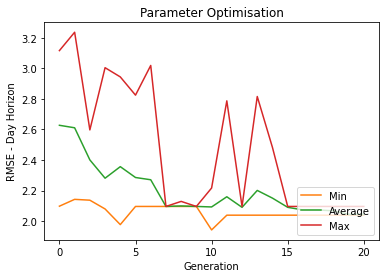

In [79]:
evolution = pd.DataFrame({'Generation': gen_day,
                         'Max RMSE': max_day,
                          'Average':avg_day,
                         'Min RMSE': min_day})

plt.title('Parameter Optimisation')
plt.plot(evolution['Generation'], evolution['Min RMSE'], 'b', color = 'C1',
         label = 'Min')
plt.plot(evolution['Generation'], evolution['Average'], 'b', color = 'C2',
         label = 'Average')
plt.plot(evolution['Generation'], evolution['Max RMSE'], 'b', color = 'C3',
         label= 'Max')


plt.legend(loc = 'lower right')
plt.ylabel('RMSE - Day Horizon')
plt.xlabel('Generation')
plt.xticks([0,5,10,15,20])

In [98]:
X_train, Y_train,_maxtrain, _mintrain, _meantrain, _stdtrain = preparing_data(df_train_micetreated, lag = day_best_parameters_1[0], normalize = day_best_parameters_1[1], category = day_best_parameters_1[2], onlyHour = day_best_parameters_1[3], onlyMonth = day_best_parameters_1[4])
X_test, Y_test,_maxtest, _mintest, _meantest, _stdtest = preparing_data(df_test_micetreated, lag = day_best_parameters_1[0], normalize = day_best_parameters_1[1], category = day_best_parameters_1[2], onlyHour = day_best_parameters_1[3], onlyMonth = day_best_parameters_1[4])

In [109]:
X_test_day = X_test[-24:].reset_index(drop=True)
Y_test_day = Y_test[-24:].reset_index(drop=True)

xgbmodel = XGBRegressor(n_estimators=day_best_parameters_1[5], 
                         max_depth=day_best_parameters_1[6],
                         eta=day_best_parameters_1[7], subsample=day_best_parameters_1[8],
                         colsample_bytree=day_best_parameters_1[9],
                         learning_rate = day_best_parameters_1[10])

xgbmodel.fit(X_train, Y_train)

testpredictXGB = multistep_prediction(xgbmodel, X_test_day, day_best_parameters_1[0])

if day_best_parameters_1[1] == 'standard':
    orig_y_eval_test_day = Y_test_day*(_stdtest) + _meantest
    orig_y_hat_test_day = testpredictXGB*(_stdtest) + _meantest
else:
    orig_y_eval_test_day = y_test_day*(_maxtest - _mintest) + _mintest
    orig_y_hat_test_day = testpredictXGB*(_maxtest - _mintest) + _mintest

mape_day = MAPE(orig_y_eval_test_day, orig_y_hat_test_day)
RMSE_test_day = (mean_squared_error(orig_y_eval_test_day, orig_y_hat_test_day))**0.5
print(f'RMSE: {RMSE_test_day}')
print(f'MAPE: {mape_day}')

RMSE: 2.3927674754208983
MAPE: Output    51.061832
Name: 0, dtype: float64


[[ 0  4]
 [ 1 19]]


Text(0.5, 15.0, 'Predicted')

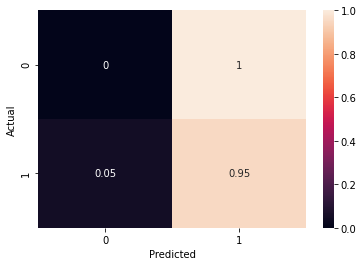

In [110]:
classification_real_day = mask_classification(orig_y_eval_test_day)
classification_forecasting_day = mask_classification(orig_y_hat_test_day)

print(confusion_matrix(classification_real_day, classification_forecasting_day))
cm_day = confusion_matrix(classification_real_day, classification_forecasting_day)

cmn_day = cm_day.astype('float') / cm_day.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn_day,annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [111]:
classification_forecasting_day

array([1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2.])

In [112]:
classification_real_day

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2.])

**Previsão Horizonte 1 semana**

**Seleção de hiper-parâmetros utilizando algoritmos genéticos**

In [115]:
from xgboost import XGBRegressor
from deap import base, creator, tools, algorithms
import random

def mutate(individual):
    
    gene = random.randint(0,10) #select which parameter to mutate
    if gene == 0:
        if individual[0] == 3:
            individual[0] = random.choice([6, 12, 24])
        elif individual[0] == 6:
            individual[0] = random.choice([3, 12, 24])
        elif individual[0] == 12:
            individual[0] = random.choice([3, 6, 24])
        else:
            individual[0] = random.choice([3, 6, 12])
    elif gene == 1:
        if individual[1] == 'minmax':
            individual[1] = 'standard'
        else:
            individual[1] = 'minmax'
    elif gene == 2:
        if individual[2] == 'numeric':
            individual[2] = random.choice(['1ofN', 'binary'])
        elif individual[2] == '1ofN':
            individual[2] = random.choice(['numeric', 'binary'])
        else:
            individual[2] = random.choice(['numeric', '1ofN'])
        
    elif gene == 3:
        if individual[3] == True:
            individual[3] = False
        else:
            individual[3] = True

    elif gene == 4:
        if individual[4] == True:
            individual[4] = False
        else:
            individual[4] = True
    elif gene == 5:
        individual[5] = random.randint(lower_n_stimators, upper_n_stimators)
    
    elif gene == 6:
        individual[6] = random.randint(lower_max_depth, upper_max_depth)
        
    elif gene == 7:
        individual[7] = random.uniform(lower_eta, upper_eta) 
        
    elif gene == 8:
        individual[8] = random.uniform(lower_subsample, upper_subsample) 
    
    elif gene == 9:
        individual[9] = random.uniform(lower_subsample, upper_subsample)
    
    elif gene == 10:
        individual[10] = random.uniform(lower_lr, upper_lr)
        
    return individual,


def evaluate(individual):
    '''
    build and test a model based on the parameters in an individual and return
    the AUROC value
    '''
    # extract the values of the parameters from the individual chromosome
    
    _lag = individual[0]
    _normalize = individual[1]
    _category = individual[2]
    _month = individual[3]
    _hour = individual[4]
    _n_stimators = individual[5]
    _max_depth = individual[6]
    _eta = individual[7]
    _subsample = individual[8]
    _colsample_bytree = individual[9]
    _lr = individual[10]
    
    print(f'Train_Lag: {_lag}')
    print(f'Train_Norm: {_normalize}')
    print(f'Train_Category: {_category}')
    print(f'Train_Hour: {_hour}')
    print(f'Train_Month: {_month}')
    X_train, Y_train,_maxtrain, _mintrain, _meantrain, _stdtrain = preparing_data(df_train_micetreated, lag = _lag, normalize = _normalize, category = _category, onlyHour = _hour, onlyMonth = _month)
    X_test, Y_test,_maxtest, _mintest, _meantest, _stdtest = preparing_data(df_test_micetreated,lag = _lag, normalize = _normalize, category = _category, onlyHour = _hour, onlyMonth = _month)    
    X_test_week = X_test[-168:].reset_index(drop=True)
    Y_test_week = Y_test[-168:].reset_index(drop=True)
    # build the model
    print(f'n_stimators: {_n_stimators}')
    print(f'max_depth: {_max_depth}')
    print(f'eta: {_eta}')
    print(f'subsample: {_subsample}')
    print(f'colsample_bytree: {_colsample_bytree}')
    print(f'learning_rate: {_lr}')
    xgbmodel = XGBRegressor(n_estimators=_n_stimators, 
                         max_depth=_max_depth,
                         eta=_eta, subsample=_subsample,
                         colsample_bytree=_colsample_bytree,
                         learning_rate = _lr)
    
    xgbmodel.fit(X_train,Y_train)

    testpredictXGB = multistep_prediction(xgbmodel, X_test_week, _lag)

    if _normalize == 'standard':
        orig_y_eval_test = Y_test_week*(_stdtest) + _meantest
        orig_y_hat_test = testpredictXGB*(_stdtest) + _meantest
    else:
        orig_y_eval_test = Y_test_week*(_maxtest - _mintest) + _mintest
        orig_y_hat_test = testpredictXGB*(_maxtest - _mintest) + _mintest
        
    mape = MAPE(orig_y_eval_test, orig_y_hat_test)
    RMSE_test = (mean_squared_error(orig_y_eval_test, orig_y_hat_test))**0.5
    print(f'RMSE: {RMSE_test}')
    print(f'MAPE: {mape}')
    print('----'*20)
    return RMSE_test,


creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Maximise the fitness function value
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Possible parameter values
lag_option = [3, 6, 12, 24]
norm = ['minmax', 'standard']
cat = ['numeric', '1ofN', 'binary']
hour = [True, False]
month = [True, False]
lower_n_stimators, upper_n_stimators = 50,500 
lower_max_depth, upper_max_depth = 1,15
lower_eta, upper_eta = 0.01,0.2
lower_subsample, upper_subsample = 0.5,1
lower_colsample_bytree, upper_colsample_bytree = 0.5,1
lower_lr, upper_lr = 0.05,0.5

N_CYCLES = 1
toolbox.register("attr_lag", random.choice, lag_option)
toolbox.register("attr_normalization", random.choice, norm)
toolbox.register("attr_category", random.choice, cat)
toolbox.register("attr_hour", random.choice, hour)
toolbox.register("attr_month", random.choice, month)
toolbox.register("attr_n_stimators", random.randint, lower_n_stimators, upper_n_stimators)
toolbox.register("attr_max_depth", random.randint, lower_max_depth, upper_max_depth)
toolbox.register("attr_eta", random.uniform, lower_eta, upper_eta)
toolbox.register("attr_subsample", random.uniform, lower_subsample, upper_subsample)
toolbox.register("attr_colsample_bytree", random.uniform, lower_colsample_bytree, upper_colsample_bytree)
toolbox.register("attr_lr", random.uniform, lower_lr, upper_lr)

toolbox.register("individual", tools.initCycle, creator.Individual,(toolbox.attr_lag,
                                                                    toolbox.attr_normalization, toolbox.attr_category,
                                                                    toolbox.attr_hour,toolbox.attr_month,
                                                                    toolbox.attr_n_stimators,toolbox.attr_max_depth,
                                                                    toolbox.attr_eta,toolbox.attr_subsample,
                                                                    toolbox.attr_colsample_bytree,toolbox.attr_lr), n=N_CYCLES)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)


toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate",mutate)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("evaluate", evaluate)

population_size = 10
crossover_probability = 0.75
mutation_probability = 0.05
number_of_generations = 20

pop = toolbox.population(n=population_size)
hof_week = tools.HallOfFame(3)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=crossover_probability, stats = stats, mutpb = mutation_probability, ngen=number_of_generations, halloffame=hof_week, verbose=True) 

week_best_parameters_1 = hof_week[0] # save the optimal set of parameters
week_best_parameters_2 = hof_week[1]
week_best_parameters_3 = hof_week[2]
print(week_best_parameters_1)
print(week_best_parameters_2)
print(week_best_parameters_3)

gen_week = log.select("gen")
max_week = log.select("max")
avg_week = log.select("avg")
min_week = log.select("min")

c:\users\diego\appdata\local\programs\python\python39\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\users\diego\appdata\local\programs\python\python39\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Train_Lag: 3
Train_Norm: standard
Train_Category: binary
Train_Hour: False
Train_Month: False
n_stimators: 460
max_depth: 12
eta: 0.09023587667302117
subsample: 0.9522594248854537
colsample_bytree: 0.6055123350239716
learning_rate: 0.298693283148001
RMSE: 2.353666170070099
MAPE: Output    117.377723
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 6
Train_Norm: standard
Train_Category: numeric
Train_Hour: False
Train_Month: True
n_stimators: 217
max_depth: 8
eta: 0.18615669270800328
subsample: 0.6414424031318333
colsample_bytree: 0.9485446119415772
learning_rate: 0.20131897551306688
RMSE: 2.3566514413265387
MAPE: Output    123.05992
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 6
Train_Norm: minmax
Train_Category: binary
Train_Hour: True
Train_Month: False
n_stimators: 104
max_depth: 1
eta: 0.05901461942070252
subsample: 0.7771313865588594
colsample_b

n_stimators: 460
max_depth: 12
eta: 0.09023587667302117
subsample: 0.9522594248854537
colsample_bytree: 0.6055123350239716
learning_rate: 0.298693283148001
RMSE: 2.3313402217358994
MAPE: Output    105.953264
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 12
Train_Norm: minmax
Train_Category: binary
Train_Hour: True
Train_Month: False
n_stimators: 342
max_depth: 10
eta: 0.07209320105351215
subsample: 0.6505492813537582
colsample_bytree: 0.8430987343450702
learning_rate: 0.49130326657004514
RMSE: 2.2887488910185607
MAPE: Output    88.681186
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 6
Train_Norm: standard
Train_Category: binary
Train_Hour: False
Train_Month: True
n_stimators: 398
max_depth: 7
eta: 0.07209320105351215
subsample: 0.6505492813537582
colsample_bytree: 0.8430987343450702
learning_rate: 0.49130326657004514
RMSE: 2.356239088858083
MAPE: O

n_stimators: 342
max_depth: 10
eta: 0.07209320105351215
subsample: 0.6505492813537582
colsample_bytree: 0.8430987343450702
learning_rate: 0.49130326657004514
RMSE: 2.2887488910185607
MAPE: Output    88.681186
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 6
Train_Norm: minmax
Train_Category: binary
Train_Hour: True
Train_Month: False
n_stimators: 342
max_depth: 10
eta: 0.07209320105351215
subsample: 0.6505492813537582
colsample_bytree: 0.8430987343450702
learning_rate: 0.49130326657004514
RMSE: 2.2472767180640756
MAPE: Output    82.928818
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 6
Train_Norm: minmax
Train_Category: binary
Train_Hour: True
Train_Month: False
n_stimators: 342
max_depth: 10
eta: 0.09023587667302117
subsample: 0.9522594248854537
colsample_bytree: 0.6055123350239716
learning_rate: 0.298693283148001
RMSE: 2.002590131051883
MAPE: Outp

RMSE: 2.1017956408599727
MAPE: Output    96.974449
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 6
Train_Norm: minmax
Train_Category: binary
Train_Hour: True
Train_Month: False
n_stimators: 342
max_depth: 10
eta: 0.07209320105351215
subsample: 0.9984113360039637
colsample_bytree: 0.597876124530243
learning_rate: 0.0876364983183337
RMSE: 2.1017956408599727
MAPE: Output    96.974449
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 6
Train_Norm: minmax
Train_Category: binary
Train_Hour: True
Train_Month: False
n_stimators: 342
max_depth: 10
eta: 0.0515349551032699
subsample: 0.9984113360039637
colsample_bytree: 0.597876124530243
learning_rate: 0.0876364983183337
RMSE: 2.1017956408599727
MAPE: Output    96.974449
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 6
Train_Norm: minmax
Train_C

n_stimators: 342
max_depth: 10
eta: 0.0515349551032699
subsample: 0.9522594248854537
colsample_bytree: 0.6055123350239716
learning_rate: 0.298693283148001
RMSE: 2.002590131051883
MAPE: Output    87.772591
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 6
Train_Norm: minmax
Train_Category: binary
Train_Hour: True
Train_Month: False
n_stimators: 342
max_depth: 10
eta: 0.0515349551032699
subsample: 0.9522594248854537
colsample_bytree: 0.6055123350239716
learning_rate: 0.298693283148001
RMSE: 2.002590131051883
MAPE: Output    87.772591
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 6
Train_Norm: minmax
Train_Category: binary
Train_Hour: True
Train_Month: False
n_stimators: 342
max_depth: 10
eta: 0.0515349551032699
subsample: 0.9522594248854537
colsample_bytree: 0.6055123350239716
learning_rate: 0.298693283148001
RMSE: 2.002590131051883
MAPE: Output    87.

RMSE: 2.002590131051883
MAPE: Output    87.772591
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 6
Train_Norm: minmax
Train_Category: binary
Train_Hour: True
Train_Month: False
n_stimators: 342
max_depth: 10
eta: 0.0515349551032699
subsample: 0.9522594248854537
colsample_bytree: 0.6055123350239716
learning_rate: 0.298693283148001
RMSE: 2.002590131051883
MAPE: Output    87.772591
Name: 0, dtype: float64
--------------------------------------------------------------------------------
13 	8     	2.00259	4.44089e-16	2.00259	2.00259
Train_Lag: 6
Train_Norm: minmax
Train_Category: binary
Train_Hour: True
Train_Month: False
n_stimators: 342
max_depth: 10
eta: 0.0515349551032699
subsample: 0.9522594248854537
colsample_bytree: 0.6055123350239716
learning_rate: 0.298693283148001
RMSE: 2.002590131051883
MAPE: Output    87.772591
Name: 0, dtype: float64
-----------------------------------------------------------------------------

n_stimators: 342
max_depth: 10
eta: 0.0515349551032699
subsample: 0.9522594248854537
colsample_bytree: 0.6055123350239716
learning_rate: 0.298693283148001
RMSE: 2.002590131051883
MAPE: Output    87.772591
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 6
Train_Norm: minmax
Train_Category: binary
Train_Hour: True
Train_Month: False
n_stimators: 342
max_depth: 10
eta: 0.0515349551032699
subsample: 0.9522594248854537
colsample_bytree: 0.6055123350239716
learning_rate: 0.298693283148001
RMSE: 2.002590131051883
MAPE: Output    87.772591
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 6
Train_Norm: minmax
Train_Category: binary
Train_Hour: True
Train_Month: False
n_stimators: 342
max_depth: 10
eta: 0.0515349551032699
subsample: 0.9522594248854537
colsample_bytree: 0.6055123350239716
learning_rate: 0.298693283148001
RMSE: 2.002590131051883
MAPE: Output    87.

RMSE: 2.002590131051883
MAPE: Output    87.772591
Name: 0, dtype: float64
--------------------------------------------------------------------------------
Train_Lag: 6
Train_Norm: minmax
Train_Category: binary
Train_Hour: True
Train_Month: False
n_stimators: 342
max_depth: 14
eta: 0.021526861258507196
subsample: 0.9522594248854537
colsample_bytree: 0.6055123350239716
learning_rate: 0.298693283148001
RMSE: 2.492400386567322
MAPE: Output    123.45453
Name: 0, dtype: float64
--------------------------------------------------------------------------------
18 	7     	2.05157	0.146943   	2.00259	2.4924 
Train_Lag: 6
Train_Norm: minmax
Train_Category: binary
Train_Hour: True
Train_Month: False
n_stimators: 342
max_depth: 10
eta: 0.12331655755770014
subsample: 0.9522594248854537
colsample_bytree: 0.6055123350239716
learning_rate: 0.298693283148001
RMSE: 2.002590131051883
MAPE: Output    87.772591
Name: 0, dtype: float64
--------------------------------------------------------------------------

<ipython-input-116-2ad9e22ced68>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(evolution['Generation'], evolution['Min RMSE'], 'b', color = 'C1',
<ipython-input-116-2ad9e22ced68>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(evolution['Generation'], evolution['Average'], 'b', color = 'C2',
<ipython-input-116-2ad9e22ced68>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(evolution['Generation'], evolution['Max RMSE'], 'b', color = 'C3',


([<matplotlib.axis.XTick at 0x1b974b1a070>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

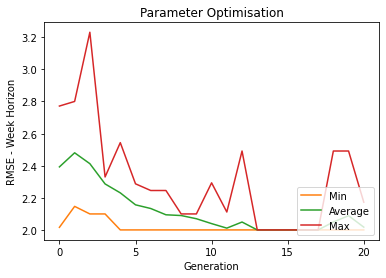

In [116]:
evolution = pd.DataFrame({'Generation': gen_week,
                         'Max RMSE': max_week,
                          'Average':avg_week,
                         'Min RMSE': min_week})

plt.title('Parameter Optimisation')
plt.plot(evolution['Generation'], evolution['Min RMSE'], 'b', color = 'C1',
         label = 'Min')
plt.plot(evolution['Generation'], evolution['Average'], 'b', color = 'C2',
         label = 'Average')
plt.plot(evolution['Generation'], evolution['Max RMSE'], 'b', color = 'C3',
         label= 'Max')


plt.legend(loc = 'lower right')
plt.ylabel('RMSE - Week Horizon')
plt.xlabel('Generation')
plt.xticks([0,5,10,15,20])

In [117]:
X_train, Y_train,_maxtrain, _mintrain, _meantrain, _stdtrain = preparing_data(df_train_micetreated, lag = week_best_parameters_1[0], normalize = week_best_parameters_1[1], category = week_best_parameters_1[2], onlyHour = week_best_parameters_1[3], onlyMonth = week_best_parameters_1[4])
X_test, Y_test,_maxtest, _mintest, _meantest, _stdtest = preparing_data(df_test_micetreated, lag = week_best_parameters_1[0], normalize = week_best_parameters_1[1], category = week_best_parameters_1[2], onlyHour = week_best_parameters_1[3], onlyMonth = week_best_parameters_1[4])

In [118]:
X_test_week = X_test[-168:].reset_index(drop=True)
Y_test_week = Y_test[-168:].reset_index(drop=True)

xgbmodel = XGBRegressor(n_estimators=155, 
                     max_depth=8,
                     eta=0.08266939204039342, subsample=week_best_parameters_1[8],
                     colsample_bytree=week_best_parameters_1[9],
                     learning_rate = week_best_parameters_1[10])

xgbmodel.fit(X_train,Y_train)

testpredictXGB_week = multistep_prediction(xgbmodel, X_test_week, week_best_parameters_1[0])

if week_best_parameters_1[1] == 'standard':
    orig_y_eval_test_week = T=Y_test_week*(_stdtest) + _meantest
    orig_y_hat_test_week = testpredictXGB_week*(_stdtest) + _meantest
else:
    orig_y_eval_test_week = Y_test_week*(_maxtest - _mintest) + _mintest
    orig_y_hat_test_week = testpredictXGB_week*(_maxtest - _mintest) + _mintest

mape_week = MAPE(orig_y_eval_test_week, orig_y_hat_test_week)
RMSE_test_week = (mean_squared_error(orig_y_eval_test_week, orig_y_hat_test_week))**0.5
print(f'RMSE: {RMSE_test_week}')
print(f'MAPE: {mape_week}')


RMSE: 2.0504766547503315
MAPE: Output    88.53099
Name: 0, dtype: float64


[[97 13]
 [54  4]]


Text(0.5, 15.0, 'Predicted')

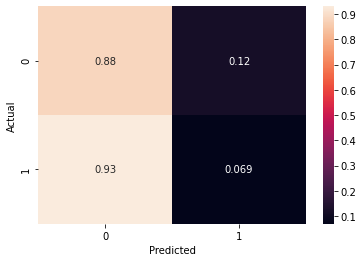

In [119]:
classification_real_week = mask_classification(orig_y_eval_test_week)
classification_forecasting_week = mask_classification(orig_y_hat_test_week)

print(confusion_matrix(classification_real_week, classification_forecasting_week))
cm_week = confusion_matrix(classification_real_week, classification_forecasting_week)

cmn_week = cm_week.astype('float') / cm_week.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn_week,annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')